In [1]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_10.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_10.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_layer 10_90.pth'

/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Only extract hidden states
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[-1].mean(dim=1).cpu().numpy())
    return np.vstack(hidden_states)

In [4]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [5]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')  # Initialize the best accuracy to negative infinity
    best_model_state = None  # Store the state of the best model
    best_epoch = 0  # Track the epoch with the best accuracy
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Best Model was saved at epoch {best_epoch} with accuracy {best_accuracy * 100:.2f}%")
    return custom_mlp, losses, best_accuracy

In [6]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 65/65 [07:26<00:00,  6.86s/it]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 81/81 [10:56<00:00,  8.11s/it]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/torch/autograd/graph.py:768: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training Epochs:   4%|▍         | 20/500 [00:00<00:05, 90.60it/s]

Epoch 10/500, Loss: 0.2790
Test Accuracy at Epoch 10: 87.18%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.86      0.92      0.89        65
non_infringement       0.89      0.81      0.85        52

        accuracy                           0.87       117
       macro avg       0.88      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117

New best model saved with accuracy 87.18% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.86      0.92      0.89        65
non_infringement       0.89      0.81      0.85        52

        accuracy                           0.87       117
       macro avg       0.88      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117

Epoch 20/500, Loss: 0.0885
Test Accuracy at Epoch 20: 91.45%
Classification Report at Epoch 20:
            

Training Epochs:   9%|▉         | 45/500 [00:00<00:04, 111.45it/s]

Epoch 30/500, Loss: 0.0444
Test Accuracy at Epoch 30: 91.45%
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.97      0.88      0.92        65
non_infringement       0.86      0.96      0.91        52

        accuracy                           0.91       117
       macro avg       0.91      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117

Epoch 40/500, Loss: 0.0372
Test Accuracy at Epoch 40: 91.45%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.97      0.88      0.92        65
non_infringement       0.86      0.96      0.91        52

        accuracy                           0.91       117
       macro avg       0.91      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117

Epoch 50/500, Loss: 0.0321
Test Accuracy at Epoch 50: 89.74%
Classification Report at Epoch 50:
          

Training Epochs:  17%|█▋        | 83/500 [00:00<00:03, 120.15it/s]

Epoch 60/500, Loss: 0.0270
Test Accuracy at Epoch 60: 90.60%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.95      0.88      0.91        65
non_infringement       0.86      0.94      0.90        52

        accuracy                           0.91       117
       macro avg       0.90      0.91      0.91       117
    weighted avg       0.91      0.91      0.91       117

Epoch 70/500, Loss: 0.0242
Test Accuracy at Epoch 70: 90.60%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.95      0.88      0.91        65
non_infringement       0.86      0.94      0.90        52

        accuracy                           0.91       117
       macro avg       0.90      0.91      0.91       117
    weighted avg       0.91      0.91      0.91       117

Epoch 80/500, Loss: 0.0234
Test Accuracy at Epoch 80: 91.45%
Classification Report at Epoch 80:
          

Training Epochs:  22%|██▏       | 109/500 [00:00<00:03, 124.70it/s]

Epoch 90/500, Loss: 0.0233
Test Accuracy at Epoch 90: 91.45%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.97      0.88      0.92        65
non_infringement       0.86      0.96      0.91        52

        accuracy                           0.91       117
       macro avg       0.91      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117

Epoch 100/500, Loss: 0.0232
Test Accuracy at Epoch 100: 91.45%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.97      0.88      0.92        65
non_infringement       0.86      0.96      0.91        52

        accuracy                           0.91       117
       macro avg       0.91      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117

Epoch 110/500, Loss: 0.0232
Test Accuracy at Epoch 110: 91.45%
Classification Report at Epoch 110:
    

Training Epochs:  27%|██▋       | 136/500 [00:01<00:02, 124.79it/s]

Epoch 120/500, Loss: 0.0232
Test Accuracy at Epoch 120: 91.45%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.97      0.88      0.92        65
non_infringement       0.86      0.96      0.91        52

        accuracy                           0.91       117
       macro avg       0.91      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117

Epoch 130/500, Loss: 0.0232
Test Accuracy at Epoch 130: 91.45%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.97      0.88      0.92        65
non_infringement       0.86      0.96      0.91        52

        accuracy                           0.91       117
       macro avg       0.91      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117

Epoch 140/500, Loss: 0.0232
Test Accuracy at Epoch 140: 91.45%
Classification Report at Epoch 140:
 

Training Epochs:  32%|███▏      | 162/500 [00:01<00:02, 123.02it/s]

Epoch 150/500, Loss: 0.0232
Test Accuracy at Epoch 150: 91.45%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.97      0.88      0.92        65
non_infringement       0.86      0.96      0.91        52

        accuracy                           0.91       117
       macro avg       0.91      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117

Epoch 160/500, Loss: 0.0232
Test Accuracy at Epoch 160: 91.45%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.97      0.88      0.92        65
non_infringement       0.86      0.96      0.91        52

        accuracy                           0.91       117
       macro avg       0.91      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117

Epoch 170/500, Loss: 0.0231
Test Accuracy at Epoch 170: 91.45%
Classification Report at Epoch 170:
 

Training Epochs:  40%|████      | 202/500 [00:01<00:02, 123.25it/s]

Epoch 180/500, Loss: 0.0233
Test Accuracy at Epoch 180: 91.45%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.97      0.88      0.92        65
non_infringement       0.86      0.96      0.91        52

        accuracy                           0.91       117
       macro avg       0.91      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117

Epoch 190/500, Loss: 0.0231
Test Accuracy at Epoch 190: 91.45%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.97      0.88      0.92        65
non_infringement       0.86      0.96      0.91        52

        accuracy                           0.91       117
       macro avg       0.91      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117

Epoch 200/500, Loss: 0.0231
Test Accuracy at Epoch 200: 91.45%
Classification Report at Epoch 200:
 

Training Epochs:  46%|████▌     | 228/500 [00:01<00:02, 124.51it/s]

Epoch 210/500, Loss: 0.0231
Test Accuracy at Epoch 210: 91.45%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.97      0.88      0.92        65
non_infringement       0.86      0.96      0.91        52

        accuracy                           0.91       117
       macro avg       0.91      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117

Epoch 220/500, Loss: 0.0231
Test Accuracy at Epoch 220: 91.45%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.97      0.88      0.92        65
non_infringement       0.86      0.96      0.91        52

        accuracy                           0.91       117
       macro avg       0.91      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117

Epoch 230/500, Loss: 0.0231
Test Accuracy at Epoch 230: 91.45%
Classification Report at Epoch 230:
 

Training Epochs:  51%|█████     | 254/500 [00:02<00:01, 123.10it/s]

Epoch 240/500, Loss: 0.0236
Test Accuracy at Epoch 240: 90.60%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.97      0.86      0.91        65
non_infringement       0.85      0.96      0.90        52

        accuracy                           0.91       117
       macro avg       0.91      0.91      0.91       117
    weighted avg       0.91      0.91      0.91       117

Epoch 250/500, Loss: 0.0231
Test Accuracy at Epoch 250: 90.60%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.97      0.86      0.91        65
non_infringement       0.85      0.96      0.90        52

        accuracy                           0.91       117
       macro avg       0.91      0.91      0.91       117
    weighted avg       0.91      0.91      0.91       117

Epoch 260/500, Loss: 0.0231
Test Accuracy at Epoch 260: 90.60%
Classification Report at Epoch 260:
 

Training Epochs:  59%|█████▊    | 293/500 [00:02<00:01, 123.67it/s]

Epoch 270/500, Loss: 0.0231
Test Accuracy at Epoch 270: 90.60%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.97      0.86      0.91        65
non_infringement       0.85      0.96      0.90        52

        accuracy                           0.91       117
       macro avg       0.91      0.91      0.91       117
    weighted avg       0.91      0.91      0.91       117

Epoch 280/500, Loss: 0.0231
Test Accuracy at Epoch 280: 90.60%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.97      0.86      0.91        65
non_infringement       0.85      0.96      0.90        52

        accuracy                           0.91       117
       macro avg       0.91      0.91      0.91       117
    weighted avg       0.91      0.91      0.91       117

Epoch 290/500, Loss: 0.0231
Test Accuracy at Epoch 290: 90.60%
Classification Report at Epoch 290:
 

Training Epochs:  64%|██████▍   | 319/500 [00:02<00:01, 126.68it/s]

Epoch 300/500, Loss: 0.0231
Test Accuracy at Epoch 300: 90.60%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.97      0.86      0.91        65
non_infringement       0.85      0.96      0.90        52

        accuracy                           0.91       117
       macro avg       0.91      0.91      0.91       117
    weighted avg       0.91      0.91      0.91       117

Epoch 310/500, Loss: 0.0231
Test Accuracy at Epoch 310: 90.60%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.97      0.86      0.91        65
non_infringement       0.85      0.96      0.90        52

        accuracy                           0.91       117
       macro avg       0.91      0.91      0.91       117
    weighted avg       0.91      0.91      0.91       117

Epoch 320/500, Loss: 0.0231
Test Accuracy at Epoch 320: 90.60%
Classification Report at Epoch 320:
 

Training Epochs:  69%|██████▉   | 345/500 [00:02<00:01, 125.48it/s]

Epoch 330/500, Loss: 0.0231
Test Accuracy at Epoch 330: 91.45%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.98      0.86      0.92        65
non_infringement       0.85      0.98      0.91        52

        accuracy                           0.91       117
       macro avg       0.92      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117

Epoch 340/500, Loss: 0.0231
Test Accuracy at Epoch 340: 91.45%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.98      0.86      0.92        65
non_infringement       0.85      0.98      0.91        52

        accuracy                           0.91       117
       macro avg       0.92      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117

Epoch 350/500, Loss: 0.0231
Test Accuracy at Epoch 350: 91.45%
Classification Report at Epoch 350:
 

Training Epochs:  77%|███████▋  | 384/500 [00:03<00:00, 125.43it/s]

Epoch 360/500, Loss: 0.0231
Test Accuracy at Epoch 360: 90.60%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.97      0.86      0.91        65
non_infringement       0.85      0.96      0.90        52

        accuracy                           0.91       117
       macro avg       0.91      0.91      0.91       117
    weighted avg       0.91      0.91      0.91       117

Epoch 370/500, Loss: 0.0232
Test Accuracy at Epoch 370: 90.60%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.97      0.86      0.91        65
non_infringement       0.85      0.96      0.90        52

        accuracy                           0.91       117
       macro avg       0.91      0.91      0.91       117
    weighted avg       0.91      0.91      0.91       117

Epoch 380/500, Loss: 0.0231
Test Accuracy at Epoch 380: 91.45%
Classification Report at Epoch 380:
 

Training Epochs:  82%|████████▏ | 410/500 [00:03<00:00, 123.92it/s]

Epoch 390/500, Loss: 0.0231
Test Accuracy at Epoch 390: 91.45%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.98      0.86      0.92        65
non_infringement       0.85      0.98      0.91        52

        accuracy                           0.91       117
       macro avg       0.92      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117

Epoch 400/500, Loss: 0.0231
Test Accuracy at Epoch 400: 91.45%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.98      0.86      0.92        65
non_infringement       0.85      0.98      0.91        52

        accuracy                           0.91       117
       macro avg       0.92      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117

Epoch 410/500, Loss: 0.0231
Test Accuracy at Epoch 410: 91.45%
Classification Report at Epoch 410:
 

Training Epochs:  87%|████████▋ | 436/500 [00:03<00:00, 124.40it/s]

Epoch 420/500, Loss: 0.0231
Test Accuracy at Epoch 420: 91.45%
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.98      0.86      0.92        65
non_infringement       0.85      0.98      0.91        52

        accuracy                           0.91       117
       macro avg       0.92      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117

Epoch 430/500, Loss: 0.0231
Test Accuracy at Epoch 430: 91.45%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.98      0.86      0.92        65
non_infringement       0.85      0.98      0.91        52

        accuracy                           0.91       117
       macro avg       0.92      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117

Epoch 440/500, Loss: 0.0231
Test Accuracy at Epoch 440: 91.45%
Classification Report at Epoch 440:
 

Training Epochs:  92%|█████████▏| 462/500 [00:03<00:00, 123.19it/s]

Epoch 450/500, Loss: 0.0232
Test Accuracy at Epoch 450: 91.45%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.98      0.86      0.92        65
non_infringement       0.85      0.98      0.91        52

        accuracy                           0.91       117
       macro avg       0.92      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117

Epoch 460/500, Loss: 0.0232
Test Accuracy at Epoch 460: 90.60%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.97      0.86      0.91        65
non_infringement       0.85      0.96      0.90        52

        accuracy                           0.91       117
       macro avg       0.91      0.91      0.91       117
    weighted avg       0.91      0.91      0.91       117

Epoch 470/500, Loss: 0.0231
Test Accuracy at Epoch 470: 91.45%
Classification Report at Epoch 470:
 

Training Epochs:  95%|█████████▌| 475/500 [00:03<00:00, 124.74it/s]

Epoch 480/500, Loss: 0.0231
Test Accuracy at Epoch 480: 91.45%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.98      0.86      0.92        65
non_infringement       0.85      0.98      0.91        52

        accuracy                           0.91       117
       macro avg       0.92      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117



Training Epochs:  98%|█████████▊| 488/500 [00:04<00:00, 72.80it/s] 

Epoch 490/500, Loss: 0.0231
Test Accuracy at Epoch 490: 91.45%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.98      0.86      0.92        65
non_infringement       0.85      0.98      0.91        52

        accuracy                           0.91       117
       macro avg       0.92      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117



Training Epochs: 100%|██████████| 500/500 [00:05<00:00, 98.65it/s]
/tmp/ipykernel_1626561/3960048660.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_sta

Epoch 500/500, Loss: 0.0231
Test Accuracy at Epoch 500: 91.45%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.98      0.86      0.92        65
non_infringement       0.85      0.98      0.91        52

        accuracy                           0.91       117
       macro avg       0.92      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117



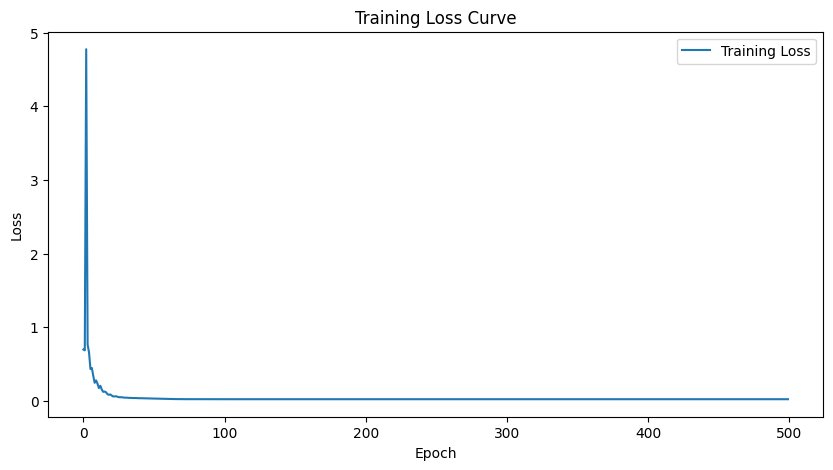

Best Model was saved at epoch 20 with accuracy 91.45%


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_layer 10_90.pth'.


In [11]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 91.45%
                  precision    recall  f1-score   support

    infringement       0.97      0.88      0.92        65
non_infringement       0.86      0.96      0.91        52

        accuracy                           0.91       117
       macro avg       0.91      0.92      0.91       117
    weighted avg       0.92      0.91      0.91       117



/tmp/ipykernel_1626561/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
